# Data Exploration

## Libraries

In [319]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
sns.set()

In [320]:
path = 'data/'
X_train = pd.read_csv( path + 'X_train.csv')
Y_train = pd.read_csv(path + 'Y_train.csv')
X_test = pd.read_csv(path + 'X_test.csv')

- ID: Unique row identifier, associated with a day (DAY_ID) and a country (COUNTRY),
- DAY_ID: Day identifier - dates have been anonymized, but all data corresponding to a specific day is consistent,
- COUNTRY: Country identifier - DE = Germany, FR = France, 

and then contains daily commodity price variations:

- GAS_RET: European gas,
- COAL_RET: European coal,
- CARBON_RET: Carbon emissions futures,

weather measures (daily, in the country x):

- x_TEMP: Temperature,
- x_RAIN: Rainfall,
- x_WIND: Wind,

energy production measures (daily, in the country x),

- x_GAS: Natural gas,
- x_COAL: Hard coal,
- x_HYDRO: Hydro reservoir,
- x_NUCLEAR: Daily nuclear production,
- x_SOLAR: Photovoltaic,
- x_WINDPOW: Wind power,
- x_LIGNITE: Lignite,

and electricity use metrics (daily, in the country x),

- x_CONSUMPTON: Total electricity consumption,
- x_RESIDUAL_LOAD: Electricity consumption after using all renewable energies,
- x_NET_IMPORT: Imported electricity from Europe,
- x_NET_EXPORT: Exported electricity to Europe,
- DE_FR_EXCHANGE: Total daily electricity exchange between Germany and France,
- FR_DE_EXCHANGE: Total daily electricity exchange between France and Germany.

Output data sets are composed of two columns:

- ID: Unique row identifier - corresponding to the input identifiers,
- TARGET: Daily price variation for futures of 24H electricity baseload.

In [321]:
data = pd.merge(X_train, Y_train, on=['ID'])
data.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,TARGET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445,0.028313
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365,-0.112516
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952,-0.180840
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948,-0.260356
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378,-0.071733


In [322]:
data.describe()

,ID,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,...,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,TARGET
count,1494.000000,1494.000000,1494.000000,1494.000000,1469.000000,1469.000000,1370.000000,1424.000000,1370.000000,1424.000000,...,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1494.000000,1494.000000,1494.000000,1494.000000
mean,1072.759036,591.861446,0.427442,-0.020032,-0.145508,0.145508,-0.256332,-0.072643,0.256332,0.072643,...,-0.037831,0.019357,0.109480,0.123099,0.009451,0.008404,0.058126,0.061724,0.080510,0.089934
std,618.013179,345.065043,0.673412,0.918995,0.970226,0.970226,0.957443,1.075830,0.957443,1.075830,...,0.984233,1.051781,1.056243,1.054692,0.972394,1.003356,1.097768,1.033853,1.098624,1.034582
min,0.000000,0.000000,-2.265563,-1.462350,-2.856874,-2.634831,-2.464849,-2.825331,-2.279619,-1.951516,...,-2.128531,-1.726420,-1.880419,-1.895319,-4.549638,-5.787097,-5.349463,-5.706442,-4.281790,-6.519268
25%,540.250000,292.250000,-0.037421,-0.716771,-0.875213,-0.638867,-0.977214,-0.851500,-0.452252,-0.794843,...,-0.642117,-0.503927,-0.652135,-0.672614,-0.618259,-0.647948,-0.624238,-0.458038,-0.522968,-0.219861
50%,1077.500000,591.000000,0.357061,-0.394166,-0.164287,0.164287,-0.306899,0.099455,0.306899,-0.099455,...,-0.274901,-0.228147,-0.261571,-0.229031,-0.026306,-0.020889,0.008493,0.063312,0.054056,0.000000
75%,1597.500000,885.750000,0.922057,0.650533,0.638867,0.875213,0.452252,0.794843,0.977214,0.851500,...,0.335237,0.154351,0.635050,0.824781,0.651832,0.699131,0.676415,0.641446,0.599094,0.269719
max,2146.000000,1215.000000,2.033851,3.300640,2.634831,2.856874,2.279619,1.951516,2.464849,2.825331,...,7.756118,9.473201,5.085624,4.965028,2.858758,2.817239,5.674778,3.746576,5.471818,7.786578


<AxesSubplot: >

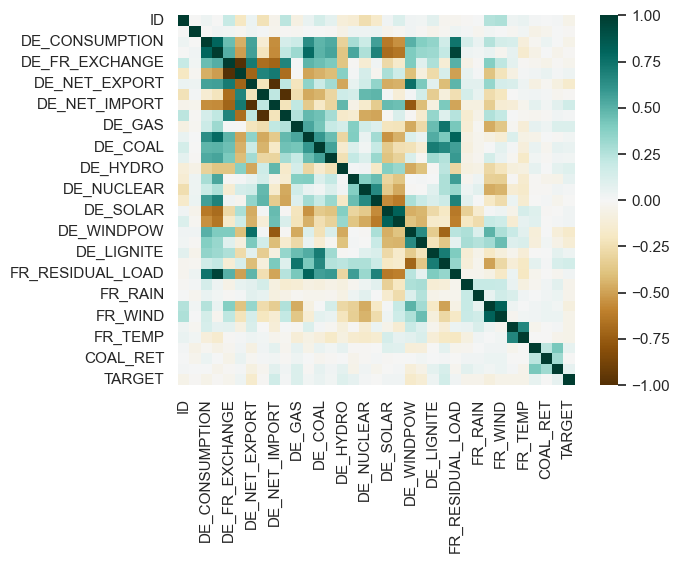

In [323]:
test = data.dropna()
sns.heatmap(test.corr(numeric_only=True),cmap='BrBG')

In [324]:
all_data = data.copy()
all_data['train'] = 1
all_data = pd.concat([all_data,X_test])
all_data['TARGET'] = all_data['TARGET'].fillna(0)
all_data['train'] = all_data['train'].fillna(0)
all_data.describe()

,ID,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,...,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,TARGET,train
count,2148.00000,2148.000000,2148.000000,2148.000000,2114.000000,2114.000000,1977.000000,2054.000000,1977.000000,2054.000000,...,2014.000000,2014.000000,2014.000000,2014.000000,2014.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000
mean,1073.50000,604.309125,0.429817,-0.003449,-0.114830,0.114830,-0.245501,-0.088621,0.245501,0.088621,...,0.008455,0.103704,0.109674,-0.005285,-0.009413,0.060070,0.072950,0.070170,0.062552,0.695531
std,620.21851,349.088770,0.714875,0.939784,0.950303,0.950303,0.952955,1.054911,0.952955,1.054911,...,1.035476,1.041639,1.031072,0.985023,1.010942,1.091539,1.023083,1.092801,0.863731,0.460289
min,0.00000,0.000000,-7.433311,-4.591011,-2.856874,-2.634831,-2.464849,-2.825331,-2.279619,-1.951516,...,-2.046479,-1.880419,-1.895319,-4.549638,-5.787097,-5.349463,-5.706442,-4.281790,-6.519268,0.000000
25%,536.75000,302.000000,-0.017582,-0.717684,-0.830239,-0.635085,-0.973313,-0.859648,-0.480707,-0.790383,...,-0.498004,-0.650091,-0.665751,-0.677700,-0.699078,-0.601147,-0.458038,-0.527112,-0.108862,0.000000
50%,1073.50000,604.000000,0.360249,-0.388808,-0.116238,0.116238,-0.293294,0.073083,0.293294,-0.073083,...,-0.243203,-0.240327,-0.222704,-0.053459,-0.049865,0.034189,0.078560,0.039072,0.000000,1.000000
75%,1610.25000,906.250000,0.960286,0.731576,0.635085,0.830239,0.480707,0.790383,0.973313,0.859648,...,0.137025,0.632464,0.744274,0.653668,0.683419,0.676415,0.683850,0.598996,0.108285,1.000000
max,2147.00000,1215.000000,2.033851,3.300640,2.634831,2.856874,2.279619,1.951516,2.464849,2.825331,...,11.489768,7.149098,4.965028,3.113181,2.817239,5.674778,3.868088,5.471818,7.786578,1.000000


In [325]:
all_data.isnull().sum()

ID                    0
DAY_ID                0
COUNTRY               0
DE_CONSUMPTION        0
FR_CONSUMPTION        0
DE_FR_EXCHANGE       34
FR_DE_EXCHANGE       34
DE_NET_EXPORT       171
FR_NET_EXPORT        94
DE_NET_IMPORT       171
FR_NET_IMPORT        94
DE_GAS                0
FR_GAS                0
DE_COAL               0
FR_COAL               0
DE_HYDRO              0
FR_HYDRO              0
DE_NUCLEAR            0
FR_NUCLEAR            0
DE_SOLAR              0
FR_SOLAR              0
DE_WINDPOW            0
FR_WINDPOW            0
DE_LIGNITE            0
DE_RESIDUAL_LOAD      0
FR_RESIDUAL_LOAD      0
DE_RAIN             134
FR_RAIN             134
DE_WIND             134
FR_WIND             134
DE_TEMP             134
FR_TEMP             134
GAS_RET               0
COAL_RET              0
CARBON_RET            0
TARGET                0
train                 0
dtype: int64

In [326]:
print("the number of samples = ", len(all_data))
print("the number of samples of France = ", len(all_data[all_data['COUNTRY']=='FR']))
print("the number of samples of France = ", len(all_data[all_data['COUNTRY']=='DE']))

the number of samples =  2148
the number of samples of France =  1216
the number of samples of France =  932


In [327]:
# For one day, we report one price in each country
print(all_data[all_data['COUNTRY']=='FR']['DAY_ID'].value_counts().value_counts())
print(all_data[all_data['COUNTRY']=='DE']['DAY_ID'].value_counts().value_counts())

1    1216
Name: DAY_ID, dtype: int64
1    932
Name: DAY_ID, dtype: int64


In [328]:
# For some days we only have the electricity price in one country
all_data['DAY_ID'].value_counts().value_counts()

2    932
1    284
Name: DAY_ID, dtype: int64

In [329]:
day_id_count = all_data['DAY_ID'].value_counts()
day_id_count_1_index = np.array(day_id_count[day_id_count<2].index)
print(len(day_id_count_1_index))
all_data['COUNTRY'][all_data['DAY_ID'].isin(day_id_count_1_index)].value_counts()

284


FR    284
Name: COUNTRY, dtype: int64

In [330]:
print(f"in 208 days,{(208/1494)*100}\% of the data, we have only the price in FR in training data")

in 208 days,13.92235609103079\% of the data, we have only the price in FR in training data


For DE, we always have the price of DE and FR.

For FR, in 208 days we don't have the corresponding price in DE.

IDEAS: 

1- Get the missing values of other columns using same DAY_ID.

2- Create a model that is able to predict the price of a country based on the price of the other country.

## Get the missing values of columns using the columns of DAY_ID

In [331]:
all_data_clean = all_data.copy() # it will represent the data without missing values
IDs = all_data_clean[['ID','COUNTRY','TARGET','DAY_ID']]
all_data_clean = all_data_clean.drop(['ID','COUNTRY','TARGET'],axis=1)
all_data_clean = all_data_clean.groupby(['DAY_ID']).mean().reset_index()
all_data_clean = pd.merge(left = all_data_clean, right = IDs, on=['DAY_ID'])

In [332]:
all_data_clean 

,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,...,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,train,ID,COUNTRY,TARGET
0,0,0.048418,-0.465067,-0.079296,0.079296,NaN,0.650577,NaN,-0.650577,0.592572,...,-1.099226,0.279885,0.583874,-1.071996,-0.074767,0.798003,1.0,1057,FR,0.108953
1,1,0.966997,1.222131,0.331356,-0.331356,0.405549,0.778627,-0.405549,-0.778627,1.111008,...,-1.465608,1.349212,0.231602,1.480313,0.931562,0.822047,1.0,1179,FR,-0.063369
2,2,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,-0.256736,1.228079,...,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,1.0,1327,FR,2.575976
3,2,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,-0.256736,1.228079,...,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,1.0,111,DE,0.861270
4,3,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,0.612133,1.588542,...,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756,1.0,2016,FR,0.068905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,1212,-0.046100,-0.520506,-0.270515,0.270515,-0.137917,-0.789824,0.137917,0.789824,0.231723,...,1.123953,-0.707839,-0.308232,0.017778,0.072168,-0.160792,1.0,1987,FR,-0.425474
2144,1213,1.407027,1.313254,-0.456126,0.456126,0.333142,-0.069222,-0.333142,0.069222,1.781433,...,NaN,NaN,NaN,-0.103642,-0.633007,0.214805,1.0,1688,FR,-3.003988
2145,1213,1.407027,1.313254,-0.456126,0.456126,0.333142,-0.069222,-0.333142,0.069222,1.781433,...,NaN,NaN,NaN,-0.103642,-0.633007,0.214805,1.0,472,DE,0.147587
2146,1214,0.803209,0.780411,0.601610,-0.601610,0.342802,0.555367,-0.342802,-0.555367,1.064102,...,-1.221443,-0.616617,-0.737496,0.251251,0.753646,0.664086,0.0,1202,FR,0.000000


In [333]:
(all_data.isnull().sum() - all_data_clean.isnull().sum())

CARBON_RET          0
COAL_RET            0
COUNTRY             0
DAY_ID              0
DE_COAL             0
DE_CONSUMPTION      0
DE_FR_EXCHANGE      0
DE_GAS              0
DE_HYDRO            0
DE_LIGNITE          0
DE_NET_EXPORT       0
DE_NET_IMPORT       0
DE_NUCLEAR          0
DE_RAIN             0
DE_RESIDUAL_LOAD    0
DE_SOLAR            0
DE_TEMP             0
DE_WIND             0
DE_WINDPOW          0
FR_COAL             0
FR_CONSUMPTION      0
FR_DE_EXCHANGE      0
FR_GAS              0
FR_HYDRO            0
FR_NET_EXPORT       0
FR_NET_IMPORT       0
FR_NUCLEAR          0
FR_RAIN             0
FR_RESIDUAL_LOAD    0
FR_SOLAR            0
FR_TEMP             0
FR_WIND             0
FR_WINDPOW          0
GAS_RET             0
ID                  0
TARGET              0
train               0
dtype: int64

No improvement, we still have the same null values

In [334]:
all_data.isnull().sum()

ID                    0
DAY_ID                0
COUNTRY               0
DE_CONSUMPTION        0
FR_CONSUMPTION        0
DE_FR_EXCHANGE       34
FR_DE_EXCHANGE       34
DE_NET_EXPORT       171
FR_NET_EXPORT        94
DE_NET_IMPORT       171
FR_NET_IMPORT        94
DE_GAS                0
FR_GAS                0
DE_COAL               0
FR_COAL               0
DE_HYDRO              0
FR_HYDRO              0
DE_NUCLEAR            0
FR_NUCLEAR            0
DE_SOLAR              0
FR_SOLAR              0
DE_WINDPOW            0
FR_WINDPOW            0
DE_LIGNITE            0
DE_RESIDUAL_LOAD      0
FR_RESIDUAL_LOAD      0
DE_RAIN             134
FR_RAIN             134
DE_WIND             134
FR_WIND             134
DE_TEMP             134
FR_TEMP             134
GAS_RET               0
COAL_RET              0
CARBON_RET            0
TARGET                0
train                 0
dtype: int64

In [335]:
all_data[all_data['FR_DE_EXCHANGE'].isnull()].isnull().sum()

ID                   0
DAY_ID               0
COUNTRY              0
DE_CONSUMPTION       0
FR_CONSUMPTION       0
DE_FR_EXCHANGE      34
FR_DE_EXCHANGE      34
DE_NET_EXPORT       34
FR_NET_EXPORT       34
DE_NET_IMPORT       34
FR_NET_IMPORT       34
DE_GAS               0
FR_GAS               0
DE_COAL              0
FR_COAL              0
DE_HYDRO             0
FR_HYDRO             0
DE_NUCLEAR           0
FR_NUCLEAR           0
DE_SOLAR             0
FR_SOLAR             0
DE_WINDPOW           0
FR_WINDPOW           0
DE_LIGNITE           0
DE_RESIDUAL_LOAD     0
FR_RESIDUAL_LOAD     0
DE_RAIN              0
FR_RAIN              0
DE_WIND              0
FR_WIND              0
DE_TEMP              0
FR_TEMP              0
GAS_RET              0
COAL_RET             0
CARBON_RET           0
TARGET               0
train                0
dtype: int64

If we don't know the exchange between FR and DE, we don't know the net import and export.
They represent 1% of the data.(Let us put them to zero)

In [336]:
all_data_clean['COUNTRY'] = all_data_clean['COUNTRY'].apply(lambda x: 0 if x =='FR' else 1)


In [337]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
remove_columns = ['ID','DAY_ID','TARGET','train']
keep = all_data_clean.columns.difference(remove_columns)
all_data_clean[keep] = imputer.fit_transform(all_data_clean[keep])
all_data_clean.isnull().sum()

DAY_ID              0
DE_CONSUMPTION      0
FR_CONSUMPTION      0
DE_FR_EXCHANGE      0
FR_DE_EXCHANGE      0
DE_NET_EXPORT       0
FR_NET_EXPORT       0
DE_NET_IMPORT       0
FR_NET_IMPORT       0
DE_GAS              0
FR_GAS              0
DE_COAL             0
FR_COAL             0
DE_HYDRO            0
FR_HYDRO            0
DE_NUCLEAR          0
FR_NUCLEAR          0
DE_SOLAR            0
FR_SOLAR            0
DE_WINDPOW          0
FR_WINDPOW          0
DE_LIGNITE          0
DE_RESIDUAL_LOAD    0
FR_RESIDUAL_LOAD    0
DE_RAIN             0
FR_RAIN             0
DE_WIND             0
FR_WIND             0
DE_TEMP             0
FR_TEMP             0
GAS_RET             0
COAL_RET            0
CARBON_RET          0
train               0
ID                  0
COUNTRY             0
TARGET              0
dtype: int64

In [339]:
all_data_clean['COUNTRY']

0       0.0
1       0.0
2       0.0
3       1.0
4       0.0
       ... 
2143    0.0
2144    0.0
2145    1.0
2146    0.0
2147    0.0
Name: COUNTRY, Length: 2148, dtype: float64

In [338]:
werw

NameError: name 'werw' is not defined

In [ ]:
all_data_clean['DE_FR_EXCHANGE'] = all_data_clean['DE_FR_EXCHANGE'].fillna(0)
all_data_clean['FR_DE_EXCHANGE'] = all_data_clean['FR_DE_EXCHANGE'].fillna(0)

In [ ]:
all_data_clean[['DE_FR_EXCHANGE','FR_DE_EXCHANGE']] #They are colinear, we should keep only one of them

,DE_FR_EXCHANGE,FR_DE_EXCHANGE
0,-0.079296,0.079296
1,0.331356,-0.331356
2,-1.102015,1.102015
3,-1.102015,1.102015
4,-1.051716,1.051716
...,...,...
2143,-0.270515,0.270515
2144,-0.456126,0.456126
2145,-0.456126,0.456126
2146,0.601610,-0.601610


In [ ]:
all_data_clean.isnull().sum()

DAY_ID                0
DE_CONSUMPTION        0
FR_CONSUMPTION        0
DE_FR_EXCHANGE        0
FR_DE_EXCHANGE        0
DE_NET_EXPORT       171
FR_NET_EXPORT        94
DE_NET_IMPORT       171
FR_NET_IMPORT        94
DE_GAS                0
FR_GAS                0
DE_COAL               0
FR_COAL               0
DE_HYDRO              0
FR_HYDRO              0
DE_NUCLEAR            0
FR_NUCLEAR            0
DE_SOLAR              0
FR_SOLAR              0
DE_WINDPOW            0
FR_WINDPOW            0
DE_LIGNITE            0
DE_RESIDUAL_LOAD      0
FR_RESIDUAL_LOAD      0
DE_RAIN             134
FR_RAIN             134
DE_WIND             134
FR_WIND             134
DE_TEMP             134
FR_TEMP             134
GAS_RET               0
COAL_RET              0
CARBON_RET            0
train                 0
ID                    0
COUNTRY               0
TARGET                0
dtype: int64

What is the relation between the net export and the exchange?

[[1.         0.70234211]
 [0.70234211 1.        ]]


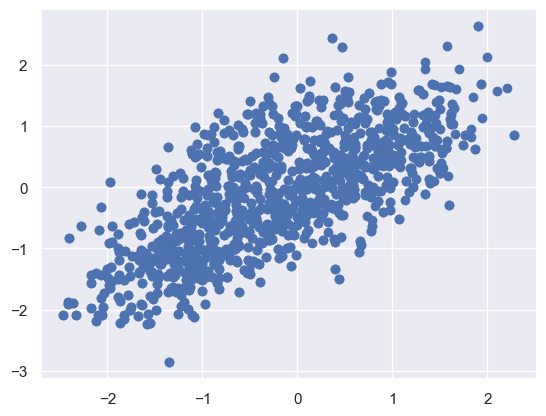

In [ ]:
test = all_data_clean.dropna()
plt.scatter(test['DE_NET_EXPORT'],test['DE_FR_EXCHANGE'])
print(np.corrcoef(test['DE_NET_EXPORT'],test['DE_FR_EXCHANGE']))
plt.show()

[[1.         0.66303994]
 [0.66303994 1.        ]]


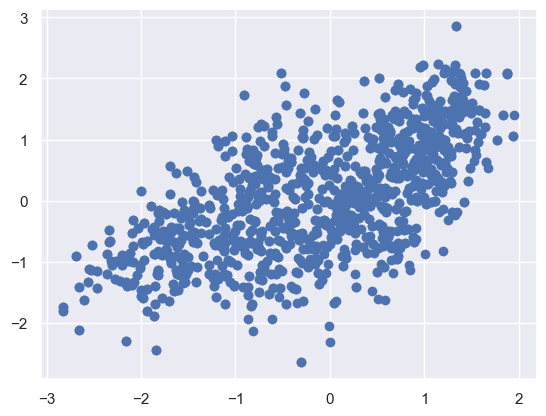

In [ ]:
test = all_data_clean.dropna()
plt.scatter(test['FR_NET_EXPORT'],test['FR_DE_EXCHANGE'])
print(np.corrcoef(test['FR_NET_EXPORT'],test['FR_DE_EXCHANGE']))
plt.show()

Let us regress the net export from the exchange

In [ ]:
def regress_var(df, x_columns, y_column, model, out = True):
    temp = df.dropna().copy()
    X = np.array(temp[x_columns])
    y = np.array(temp[y_column])
    model.fit(X,y)
    if(out):
        print("Model score", model.score(X,y))
    return df.apply(lambda row: model.predict(np.array(row[x_columns]).reshape(-1,len(x_columns)))[0] if(np.isnan(row[y_column])) else row[y_column], axis=1)


In [ ]:
x_columns = ['DE_FR_EXCHANGE']
y_column = 'DE_NET_EXPORT'
all_data_clean[y_column] = regress_var(all_data_clean, x_columns, y_column, LinearRegression(), out=True)
all_data_clean['DE_NET_IMPORT'] = - all_data_clean['DE_NET_EXPORT']
all_data_clean

Model score 0.49328444244850245


,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,...,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,train,ID,COUNTRY,TARGET
0,0,0.048418,-0.465067,-0.079296,0.079296,-0.242760,0.650577,0.242760,-0.650577,0.592572,...,-1.099226,0.279885,0.583874,-1.071996,-0.074767,0.798003,1.0,1057,0,0.108953
1,1,0.966997,1.222131,0.331356,-0.331356,0.405549,0.778627,-0.405549,-0.778627,1.111008,...,-1.465608,1.349212,0.231602,1.480313,0.931562,0.822047,1.0,1179,0,-0.063369
2,2,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,-0.256736,1.228079,...,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,1.0,1327,0,2.575976
3,2,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,-0.256736,1.228079,...,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,1.0,111,1,0.861270
4,3,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,0.612133,1.588542,...,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756,1.0,2016,0,0.068905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,1212,-0.046100,-0.520506,-0.270515,0.270515,-0.137917,-0.789824,0.137917,0.789824,0.231723,...,1.123953,-0.707839,-0.308232,0.017778,0.072168,-0.160792,1.0,1987,0,-0.425474
2144,1213,1.407027,1.313254,-0.456126,0.456126,0.333142,-0.069222,-0.333142,0.069222,1.781433,...,NaN,NaN,NaN,-0.103642,-0.633007,0.214805,1.0,1688,0,-3.003988
2145,1213,1.407027,1.313254,-0.456126,0.456126,0.333142,-0.069222,-0.333142,0.069222,1.781433,...,NaN,NaN,NaN,-0.103642,-0.633007,0.214805,1.0,472,1,0.147587
2146,1214,0.803209,0.780411,0.601610,-0.601610,0.342802,0.555367,-0.342802,-0.555367,1.064102,...,-1.221443,-0.616617,-0.737496,0.251251,0.753646,0.664086,0.0,1202,0,0.000000


In [ ]:
x_columns = ['FR_DE_EXCHANGE']
y_column = 'FR_NET_EXPORT'
all_data_clean[y_column] = regress_var(all_data_clean, x_columns, y_column, LinearRegression(), out=True)
all_data_clean['FR_NET_IMPORT'] = - all_data_clean['FR_NET_EXPORT']
all_data_clean

Model score 0.4424460230408356


,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,...,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,train,ID,COUNTRY,TARGET
0,0,0.048418,-0.465067,-0.079296,0.079296,-0.242760,0.650577,0.242760,-0.650577,0.592572,...,-1.099226,0.279885,0.583874,-1.071996,-0.074767,0.798003,1.0,1057,0,0.108953
1,1,0.966997,1.222131,0.331356,-0.331356,0.405549,0.778627,-0.405549,-0.778627,1.111008,...,-1.465608,1.349212,0.231602,1.480313,0.931562,0.822047,1.0,1179,0,-0.063369
2,2,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,-0.256736,1.228079,...,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,1.0,1327,0,2.575976
3,2,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,-0.256736,1.228079,...,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,1.0,111,1,0.861270
4,3,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,0.612133,1.588542,...,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756,1.0,2016,0,0.068905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,1212,-0.046100,-0.520506,-0.270515,0.270515,-0.137917,-0.789824,0.137917,0.789824,0.231723,...,1.123953,-0.707839,-0.308232,0.017778,0.072168,-0.160792,1.0,1987,0,-0.425474
2144,1213,1.407027,1.313254,-0.456126,0.456126,0.333142,-0.069222,-0.333142,0.069222,1.781433,...,NaN,NaN,NaN,-0.103642,-0.633007,0.214805,1.0,1688,0,-3.003988
2145,1213,1.407027,1.313254,-0.456126,0.456126,0.333142,-0.069222,-0.333142,0.069222,1.781433,...,NaN,NaN,NaN,-0.103642,-0.633007,0.214805,1.0,472,1,0.147587
2146,1214,0.803209,0.780411,0.601610,-0.601610,0.342802,0.555367,-0.342802,-0.555367,1.064102,...,-1.221443,-0.616617,-0.737496,0.251251,0.753646,0.664086,0.0,1202,0,0.000000


In [ ]:
all_data_clean.isnull().sum()

DAY_ID                0
DE_CONSUMPTION        0
FR_CONSUMPTION        0
DE_FR_EXCHANGE        0
FR_DE_EXCHANGE        0
DE_NET_EXPORT         0
FR_NET_EXPORT         0
DE_NET_IMPORT         0
FR_NET_IMPORT         0
DE_GAS                0
FR_GAS                0
DE_COAL               0
FR_COAL               0
DE_HYDRO              0
FR_HYDRO              0
DE_NUCLEAR            0
FR_NUCLEAR            0
DE_SOLAR              0
FR_SOLAR              0
DE_WINDPOW            0
FR_WINDPOW            0
DE_LIGNITE            0
DE_RESIDUAL_LOAD      0
FR_RESIDUAL_LOAD      0
DE_RAIN             134
FR_RAIN             134
DE_WIND             134
FR_WIND             134
DE_TEMP             134
FR_TEMP             134
GAS_RET               0
COAL_RET              0
CARBON_RET            0
train                 0
ID                    0
COUNTRY               0
TARGET                0
dtype: int64

In [ ]:
all_data_clean = all_data_clean.drop(['DE_FR_EXCHANGE', 'FR_NET_IMPORT','DE_NET_IMPORT'],axis=1)
all_data_clean['FR_NET_EXPORT'] -= all_data_clean['FR_DE_EXCHANGE']
all_data_clean['DE_NET_EXPORT'] += all_data_clean['FR_DE_EXCHANGE']

Replace all the other by the mean for the moment

In [ ]:
all_data_clean = all_data_clean.fillna(all_data_clean.mean(numeric_only=True))
all_data_clean

,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,...,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,train,ID,COUNTRY,TARGET
0,0,0.048418,-0.465067,0.079296,-0.163464,0.571281,0.592572,-0.261565,0.534535,0.095197,...,-1.099226,0.279885,0.583874,-1.071996,-0.074767,0.798003,1.0,1057,0,0.108953
1,1,0.966997,1.222131,-0.331356,0.074193,1.109983,1.111008,1.991028,0.660390,-0.786509,...,-1.465608,1.349212,0.231602,1.480313,0.931562,0.822047,1.0,1179,0,-0.063369
2,2,-0.068972,-0.667390,1.102015,0.021612,-0.845279,1.228079,0.458302,-0.247704,-0.766904,...,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,1.0,1327,0,2.575976
3,2,-0.068972,-0.667390,1.102015,0.021612,-0.845279,1.228079,0.458302,-0.247704,-0.766904,...,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,1.0,111,1,0.861270
4,3,-0.134670,-0.834564,1.051716,-0.830165,-1.663849,1.588542,0.069297,-0.635452,-0.718729,...,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756,1.0,2016,0,0.068905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,1212,-0.046100,-0.520506,0.270515,0.132599,-1.060340,0.231723,0.625656,-0.491812,-0.776785,...,1.123953,-0.707839,-0.308232,0.017778,0.072168,-0.160792,1.0,1987,0,-0.425474
2144,1213,1.407027,1.313254,0.456126,0.789269,-0.525349,1.781433,1.549682,-0.451947,-0.291751,...,0.109674,-0.005285,-0.009413,-0.103642,-0.633007,0.214805,1.0,1688,0,-3.003988
2145,1213,1.407027,1.313254,0.456126,0.789269,-0.525349,1.781433,1.549682,-0.451947,-0.291751,...,0.109674,-0.005285,-0.009413,-0.103642,-0.633007,0.214805,1.0,472,1,0.147587
2146,1214,0.803209,0.780411,-0.601610,-0.258809,1.156978,1.064102,1.807256,0.089534,-0.792111,...,-1.221443,-0.616617,-0.737496,0.251251,0.753646,0.664086,0.0,1202,0,0.000000


In [ ]:
all_data_clean.isnull().sum()

DAY_ID              0
DE_CONSUMPTION      0
FR_CONSUMPTION      0
FR_DE_EXCHANGE      0
DE_NET_EXPORT       0
FR_NET_EXPORT       0
DE_GAS              0
FR_GAS              0
DE_COAL             0
FR_COAL             0
DE_HYDRO            0
FR_HYDRO            0
DE_NUCLEAR          0
FR_NUCLEAR          0
DE_SOLAR            0
FR_SOLAR            0
DE_WINDPOW          0
FR_WINDPOW          0
DE_LIGNITE          0
DE_RESIDUAL_LOAD    0
FR_RESIDUAL_LOAD    0
DE_RAIN             0
FR_RAIN             0
DE_WIND             0
FR_WIND             0
DE_TEMP             0
FR_TEMP             0
GAS_RET             0
COAL_RET            0
CARBON_RET          0
train               0
ID                  0
COUNTRY             0
TARGET              0
dtype: int64

In [ ]:
all_data_clean.var() # It seems that they are already normalized

DAY_ID              121862.969139
DE_CONSUMPTION           0.511046
FR_CONSUMPTION           0.883194
FR_DE_EXCHANGE           0.888981
DE_NET_EXPORT            0.516654
FR_NET_EXPORT            0.652867
DE_GAS                   0.738787
FR_GAS                   0.844223
DE_COAL                  0.709110
FR_COAL                  0.256021
DE_HYDRO                 1.173003
FR_HYDRO                 1.154479
DE_NUCLEAR               0.848962
FR_NUCLEAR               0.938832
DE_SOLAR                 1.159389
FR_SOLAR                 1.174601
DE_WINDPOW               1.128036
FR_WINDPOW               1.342158
DE_LIGNITE               0.717010
DE_RESIDUAL_LOAD         0.732905
FR_RESIDUAL_LOAD         0.836299
DE_RAIN                  1.027548
FR_RAIN                  1.005292
DE_WIND                  1.017293
FR_WIND                  0.996758
DE_TEMP                  0.909713
FR_TEMP                  0.958218
GAS_RET                  1.191458
COAL_RET                 1.046699
CARBON_RET    

In [ ]:
test =  all_data_clean[all_data_clean['train']==1][['DAY_ID','COUNTRY','TARGET']]
FR = test[test['COUNTRY'] == 0]
DE = test[test['COUNTRY'] == 1]

In [ ]:
both = pd.merge(left=DE,right=FR,on='DAY_ID')
both = both[['TARGET_x','TARGET_y']]
both

,TARGET_x,TARGET_y
0,0.861270,2.575976
1,7.138604,0.068905
2,0.026374,1.031308
3,-0.021227,-0.118915
4,0.042996,-0.157486
...,...,...
638,-0.091774,1.877651
639,-1.324555,-0.729755
640,0.060380,0.136028
641,-0.144320,-0.425474


They are uncorrelated, let us build different model for each one

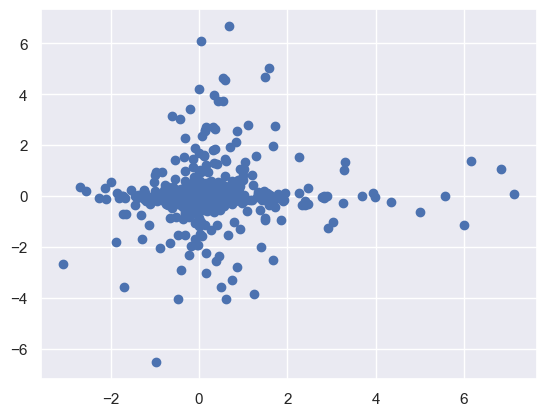

          TARGET_x  TARGET_y
TARGET_x  1.000000  0.092916
TARGET_y  0.092916  1.000000


In [ ]:
plt.scatter(both['TARGET_x'],both['TARGET_y'])
plt.show()
print(both.corr())

In [ ]:
X_train = all_data_clean[all_data_clean['train'] == 1].drop(['train','TARGET','ID','DAY_ID','COUNTRY'],axis=1)
X_test = all_data_clean[all_data_clean['train'] == 0].drop(['train','TARGET','DAY_ID','COUNTRY'],axis=1)
id_test = X_test['ID']
X_test = X_test.drop('ID',axis=1)
y_train = all_data_clean[all_data_clean['train'] == 1]['TARGET']

In [ ]:
all_data_clean['train'].sum()
X_train

,DE_CONSUMPTION,FR_CONSUMPTION,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,0.048418,-0.465067,0.079296,-0.163464,0.571281,0.592572,-0.261565,0.534535,0.095197,1.312903,...,-0.344706,-0.987968,-0.856204,-0.655528,-1.099226,0.279885,0.583874,-1.071996,-0.074767,0.798003
1,0.966997,1.222131,-0.331356,0.074193,1.109983,1.111008,1.991028,0.660390,-0.786509,-0.681081,...,1.214288,-0.370990,-0.497520,-1.184018,-1.465608,1.349212,0.231602,1.480313,0.931562,0.822047
2,-0.068972,-0.667390,1.102015,0.021612,-0.845279,1.228079,0.458302,-0.247704,-0.766904,1.785758,...,-0.540642,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434
3,-0.068972,-0.667390,1.102015,0.021612,-0.845279,1.228079,0.458302,-0.247704,-0.766904,1.785758,...,-0.540642,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434
4,-0.134670,-0.834564,1.051716,-0.830165,-1.663849,1.588542,0.069297,-0.635452,-0.718729,1.994144,...,-0.856321,-1.394561,-1.118297,0.244859,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2142,-0.046100,-0.520506,0.270515,0.132599,-1.060340,0.231723,0.625656,-0.491812,-0.776785,-0.441138,...,-0.589767,-0.039379,-0.237434,1.358211,1.123953,-0.707839,-0.308232,0.017778,0.072168,-0.160792
2143,-0.046100,-0.520506,0.270515,0.132599,-1.060340,0.231723,0.625656,-0.491812,-0.776785,-0.441138,...,-0.589767,-0.039379,-0.237434,1.358211,1.123953,-0.707839,-0.308232,0.017778,0.072168,-0.160792
2144,1.407027,1.313254,0.456126,0.789269,-0.525349,1.781433,1.549682,-0.451947,-0.291751,-0.749000,...,0.868310,-0.000009,0.008455,0.103704,0.109674,-0.005285,-0.009413,-0.103642,-0.633007,0.214805
2145,1.407027,1.313254,0.456126,0.789269,-0.525349,1.781433,1.549682,-0.451947,-0.291751,-0.749000,...,0.868310,-0.000009,0.008455,0.103704,0.109674,-0.005285,-0.009413,-0.103642,-0.633007,0.214805


In [ ]:
X_train_FR = all_data_clean[(all_data_clean['train'] == 1) & (all_data_clean['COUNTRY'] == 0)].drop(['train','TARGET','ID','DAY_ID','COUNTRY'],axis=1)
X_train_DE = all_data_clean[(all_data_clean['train'] == 1) & (all_data_clean['COUNTRY'] == 1)].drop(['train','TARGET','ID','DAY_ID','COUNTRY'],axis=1)
y_train_FR = all_data_clean[(all_data_clean['train'] == 1) & (all_data_clean['COUNTRY'] == 0)]['TARGET']
y_train_DE = all_data_clean[(all_data_clean['train'] == 1) & (all_data_clean['COUNTRY'] == 1)]['TARGET']

X_test_FR = all_data_clean[(all_data_clean['train'] == 0) & (all_data_clean['COUNTRY'] == 0)].drop(['train','TARGET','DAY_ID','COUNTRY'],axis=1)
id_test_FR = X_test_FR['ID']
X_test_FR = X_test_FR.drop('ID',axis=1)

X_test_DE = all_data_clean[(all_data_clean['train'] == 0) & (all_data_clean['COUNTRY'] == 1)].drop(['train','TARGET','DAY_ID','COUNTRY'],axis=1)
id_test_DE = X_test_DE['ID']
X_test_DE = X_test_DE.drop('ID',axis=1)

# PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
def pca_train_test(X_train, X_test, n_components = 5):
    pca = PCA(n_components =n_components)
    X_train_PCA = pca.fit_transform(X_train)
    X_test_PCA = pca.transform(X_test)
    return X_train_PCA,X_test_PCA

# Create the cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

def my_custom_loss_func_exp(y_true, y_pred):
    return spearmanr(np.exp(y_true), np.exp(y_pred)).correlation  

def my_custom_loss_func(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

def evaluate_model(X, y, model, loss = my_custom_loss_func,  cv = 5):
    scores = cross_val_score(model, X, y, cv=cv, scoring = make_scorer(loss))
    print('scores = ', scores)
    print(scores.mean())
    #full train
    model.fit(X,y)
    train_score = loss(model.predict(X),y)
    print("Full train_score = ", train_score)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=40)
    model.fit(X_train,y_train)
    train_score = loss(model.predict(X_train),y_train)
    test_score = loss(model.predict(X_test),y_test)
    print("train_score = ", train_score)
    print("test_score = ",test_score)
    return [scores.mean(),test_score]
    

Benchmark

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn import metrics
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV

valid_metric =['additive_chi2', 'chi2', 'linear', 'poly', 'polynomial', 'rbf',
        'laplacian', 'sigmoid', 'cosine']

In [ ]:
lasso_parameters = {
 'alpha': np.arange(0.00, 1.0, 0.005)
 }
model = Lasso()
#evaluate_model(X_train, y_train, model)
clf = GridSearchCV(model, # model
     param_grid = lasso_parameters, # hyperparameters
     scoring= make_scorer(my_custom_loss_func), # metric for scoring
     cv=5,
     n_jobs=-1, error_score='raise', verbose=3)
clf.fit(X_train, y_train)

In [ ]:
clf.best_estimator_

Lasso(alpha=0.005)

In [ ]:
'''
model = Lasso()
#evaluate_model(X_train, y_train, model)
clf = GridSearchCV(model, # model
     param_grid = lasso_parameters, # hyperparameters
     scoring= make_scorer(my_custom_loss_func_exp), # metric for scoring
     cv=5,
     n_jobs=-1, error_score='raise', verbose=3)
clf.fit(X_train, np.log(y_train+7))
clf.best_estimator_
evaluate_model(X_train, np.log(y_train+7), model, loss = my_custom_loss_func_exp)
'''

"\nmodel = Lasso()\n#evaluate_model(X_train, y_train, model)\nclf = GridSearchCV(model, # model\n     param_grid = lasso_parameters, # hyperparameters\n     scoring= make_scorer(my_custom_loss_func_exp), # metric for scoring\n     cv=5,\n     n_jobs=-1, error_score='raise', verbose=3)\nclf.fit(X_train, np.log(y_train+7))\nclf.best_estimator_\nevaluate_model(X_train, np.log(y_train+7), model, loss = my_custom_loss_func_exp)\n"

In [ ]:
'''
for i in range(1,X_train.shape[1]):
    print(i)
    X_train_pca, X_test_pca = pca_train_test(X_train,X_test,n_components = i)
    evaluate_model(X_train_pca, y_train, model)
'''

'\nfor i in range(1,X_train.shape[1]):\n    print(i)\n    X_train_pca, X_test_pca = pca_train_test(X_train,X_test,n_components = i)\n    evaluate_model(X_train_pca, y_train, model)\n'

In [ ]:
'''
for i in range(1,X_train.shape[1]):
    print(i)
    X_train_pca, X_test_pca = pca_train_test(X_train,X_test,n_components = i)
    evaluate_model(X_train_pca, np.log(y_train+10), model,loss = my_custom_loss_func_exp)
'''

'\nfor i in range(1,X_train.shape[1]):\n    print(i)\n    X_train_pca, X_test_pca = pca_train_test(X_train,X_test,n_components = i)\n    evaluate_model(X_train_pca, np.log(y_train+10), model,loss = my_custom_loss_func_exp)\n'

It seems the projection on PCA very stable.

In [ ]:
'''
X_train_pca, X_test_pca = pca_train_test(X_train,X_test,n_components = X_train.shape[1])
evaluate_model(X_train_pca, y_train, model,loss = my_custom_loss_func)
'''

'\nX_train_pca, X_test_pca = pca_train_test(X_train,X_test,n_components = X_train.shape[1])\nevaluate_model(X_train_pca, y_train, model,loss = my_custom_loss_func)\n'

Let us choose the best pca projection at each iteration

In [ ]:
'''
best = []
acc = []
for i in range(1,X_train_pca.shape[1]):
    print(i)
    loss = my_custom_loss_func
    clf = SequentialFeatureSelector(model, n_features_to_select=i, cv = 5 , scoring= make_scorer(loss))
    clf.fit(X_train_pca, (y_train))
    best.append(clf.get_support())
    X_train_pca_filter = X_train_pca[:,clf.get_support()]
    acc.append(evaluate_model(X_train_pca_filter, y_train, model,loss = my_custom_loss_func))
'''

'\nbest = []\nacc = []\nfor i in range(1,X_train_pca.shape[1]):\n    print(i)\n    loss = my_custom_loss_func\n    clf = SequentialFeatureSelector(model, n_features_to_select=i, cv = 5 , scoring= make_scorer(loss))\n    clf.fit(X_train_pca, (y_train))\n    best.append(clf.get_support())\n    X_train_pca_filter = X_train_pca[:,clf.get_support()]\n    acc.append(evaluate_model(X_train_pca_filter, y_train, model,loss = my_custom_loss_func))\n'

In [ ]:
'''
best_features = best[11]
X_train_pca_filter = X_train_pca[:,best_features]
evaluate_model(X_train_pca_filter, np.log(y_train+7), model,loss = my_custom_loss_func_exp, cv = KFold(shuffle=True, n_splits=2))
'''

'\nbest_features = best[11]\nX_train_pca_filter = X_train_pca[:,best_features]\nevaluate_model(X_train_pca_filter, np.log(y_train+7), model,loss = my_custom_loss_func_exp, cv = KFold(shuffle=True, n_splits=2))\n'

# Submission

In [ ]:
lasso_parameters = {
 'alpha': np.arange(0.1, 1, 0.1)
 }

In [ ]:
model = Ridge()
#evaluate_model(X_train, y_train, model)
clf = GridSearchCV(model, # model
     param_grid = lasso_parameters, # hyperparameters
     scoring= make_scorer(my_custom_loss_func), # metric for scoring
     cv=5,
     n_jobs=-1, error_score='raise', verbose=3)
clf.fit(X_train_FR, y_train_FR)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, error_score='raise', estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
             scoring=make_scorer(my_custom_loss_func), verbose=3)

In [ ]:
clf.best_params_

{'alpha': 0.9}

In [ ]:
model = Lasso()
#evaluate_model(X_train, y_train, model)
clf = GridSearchCV(model, # model
     param_grid = lasso_parameters, # hyperparameters
     scoring= make_scorer(my_custom_loss_func), # metric for scoring
     cv=5,
     n_jobs=-1, error_score='raise', verbose=3)
clf.fit(X_train_DE, y_train_DE)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\aliha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [0.33437491 0.30297628        nan        nan        nan        nan
        nan        nan        nan]
  warnings.warn(


GridSearchCV(cv=5, error_score='raise', estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
             scoring=make_scorer(my_custom_loss_func), verbose=3)

In [ ]:
clf.best_params_

{'alpha': 0.1}

In [ ]:
'''
from sklearn.multioutput import MultiOutputRegressor
gsc = GridSearchCV(
            estimator=XGBRegressor(),
            param_grid={"learning_rate": (0.05, 0.10, 0.15),
                        "max_depth": [ 3, 4, 5, 6, 8],
                        "min_child_weight": [ 1, 3, 5, 7],
                        "gamma":[ 0.0, 0.1, 0.2],
                        "colsample_bytree":[ 0.3, 0.4],},
            cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train)
gsc.best_estimator_
model = gsc.best_estimator_
evaluate_model(X_train, y_train, model)
'''

'\nfrom sklearn.multioutput import MultiOutputRegressor\ngsc = GridSearchCV(\n            estimator=XGBRegressor(),\n            param_grid={"learning_rate": (0.05, 0.10, 0.15),\n                        "max_depth": [ 3, 4, 5, 6, 8],\n                        "min_child_weight": [ 1, 3, 5, 7],\n                        "gamma":[ 0.0, 0.1, 0.2],\n                        "colsample_bytree":[ 0.3, 0.4],},\n            cv=3, scoring=\'neg_mean_squared_error\', verbose=0, n_jobs=-1)\n\ngrid_result = gsc.fit(X_train, y_train)\ngsc.best_estimator_\nmodel = gsc.best_estimator_\nevaluate_model(X_train, y_train, model)\n'

In [ ]:
model_DE = Lasso(0.01343999999999986)
evaluate_model(X_train_DE, y_train_DE, model_DE)
model_DE.fit(X_train_DE, y_train_DE)
y_test_DE = model_DE.predict(X_test_DE)

model_FR = XGBRegressor()
evaluate_model(X_train_FR, y_train_FR, model_FR)
model_FR.fit(X_train_FR,y_train_FR)
y_test_FR = model_FR.predict(X_test_FR)

scores =  [0.43537008 0.39383386 0.38279852 0.31880081 0.34172427]
0.3745055090029461
Full train_score =  0.417178566268247
train_score =  0.3933008555142047
test_score =  0.4219284945258387
scores =  [0.19577843 0.11931901 0.13825645 0.0818889  0.05169607]
0.11738777133452358
Full train_score =  0.9989016865897915
train_score =  0.9997702929122281
test_score =  0.07496458519894621


In [ ]:
sub = pd.DataFrame()
sub['ID'] = id_test
sub['TARGET'] = y_sub
#sub.to_csv("submissions/5_sub_2_different_models.csv",index=False)

NameError: name 'y_sub' is not defined

In [ ]:
stop

In [ ]:
from scipy.optimize import NonlinearConstraint
from scipy.optimize import LinearConstraint

In [ ]:
from scipy.optimize import minimize
import numpy as np

def mean_absolute_percentage_error(y_pred, y_true, sample_weights=None):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    assert len(y_true) == len(y_pred)
    
    if np.any(y_true==0):
        print("Found zeroes in y_true. MAPE undefined. Removing from set...")
        idx = np.where(y_true==0)
        y_true = np.delete(y_true, idx)
        y_pred = np.delete(y_pred, idx)
        if type(sample_weights) != type(None):
            sample_weights = np.array(sample_weights)
            sample_weights = np.delete(sample_weights, idx)
        
    if type(sample_weights) == type(None):
        return(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)
    else:
        sample_weights = np.array(sample_weights)
        assert len(sample_weights) == len(y_true)
        return(100/sum(sample_weights)*np.dot(
                sample_weights, (np.abs((y_true - y_pred) / y_true))
        ))
 

    

class CustomLinearModel:
    """
    Linear model: Y = XB, fit by minimizing the provided loss_function
    with L2 regularization
    """
    def __init__(self, loss_function=mean_absolute_percentage_error, 
                 X=None, Y=None, sample_weights=None, beta_init=None, 
                 regularization=0.001):
        self.regularization = regularization
        self.beta = None
        self.loss_function = loss_function
        self.sample_weights = sample_weights
        self.beta_init = beta_init
        
        self.X = X
        self.Y = Y
            
    def clip_beta(self):
        self.beta[np.abs(self.beta) < 1e-5] = 0
    
    def cons_f(self,beta):
        return np.var(self.X@beta)
    def cons_J(x):
        return [[2*x[0], 1], [2*x[0], -1]]
    def cons_H(x, v):
        return v[0]*np.array([[2, 0], [0, 0]]) + v[1]*np.array([[2, 0], [0, 0]])
    
    
    
    def predict(self, X):
        prediction = X@self.beta
        return(prediction)

    def model_error(self):
        error = self.loss_function(
            self.predict(self.X), self.Y, sample_weights=self.sample_weights
        )
        return(error)
    
    def l2_regularized_loss(self, beta):
        self.beta = beta
        return(self.model_error() + \
               sum(self.regularization*np.abs(np.array(self.beta))))
    
    def fit(self, maxiter=1000000):        
        # Initialize beta estimates (you may need to normalize
        # your data and choose smarter initialization values
        # depending on the shape of your loss function)
        if type(self.beta_init)==type(None):
            # set beta_init = 1 for every feature
            self.beta_init = np.array([1]*self.X.shape[1])
        else: 
            # Use provided initial values
            pass
            
        if self.beta!=None and all(self.beta_init == self.beta):
            print("Model already fit once; continuing fit with more itrations.")
        
        
        nonlinear_constraint = NonlinearConstraint(self.cons_f, 0.8, 1.2,jac='2-point')
        res = minimize(self.l2_regularized_loss, self.beta_init,
                       method='Powell', options={'maxiter': maxiter}) #constraints=nonlinear_constraint)
        self.beta = res.x
        self.beta_init = self.beta
        self.clip_beta()



In [ ]:
def mean_square_error(y_pred,y_true, sample_weights=None):
    return np.mean((y_pred-y_true)**2)
def error_corr(y_pred,y_true, sample_weights = None):
    return  1 - spearmanr(y_true, y_pred).correlation
    #return np.mean((y_pred-y_true)**2) - np.mean(y_pred**2)

In [ ]:
l1_lasso_model = CustomLinearModel(
    loss_function = error_corr,
    X=np.array(X_train), Y=np.array(y_train), regularization=0.008
)
l1_lasso_model.fit()
print(l1_lasso_model.beta)
y_pred = l1_lasso_model.predict(X_train)
print(my_custom_loss_func(y_pred,y_train))
print(np.var(y_pred),np.var(y_train))
plt.scatter(y_pred,y_train)

In [ ]:
model = Lasso(0.0151)
evaluate_model(X_train, y_train, model)
model.fit(X_train,y_train)
y_sub = model.predict(X_test)

sub = pd.DataFrame()
sub['ID'] = id_test
sub['TARGET'] = y_sub
#sub.to_csv("submissions/best_model.csv",index=False)

In [ ]:
y1 = pd.read_csv("submissions/best_model.csv")
y2 = pd.read_csv("submissions/4_sub.csv")

In [ ]:
y1

In [ ]:
y2

In [ ]:
test = pd.merge(y1,y2,on='ID')
test.corr()